In [2]:
### 数据读取，以及格式规定
from keras.preprocessing.image import ImageDataGenerator

train_dir = 'datas/train'
validation_dir = 'datas/validation'

train_datagen = ImageDataGenerator(rescale = 1./255) #缩放图片1/255
test_datagen = ImageDataGenerator(rescale = 1./255) #缩放图片1/255

train_generator = train_datagen.flow_from_directory(
        train_dir, #目标目录
        target_size = (224,224), #图片都调整为150*150的格式大小
        batch_size = 20,
        class_mode = 'binary') #使用二进制标签
validation_generator = test_datagen.flow_from_directory(
        validation_dir, #目标目录
        target_size = (224,224), #图片都调整为150*150的格式大小
        batch_size = 20,
        class_mode = 'binary') #使用二进制标签

Found 2868 images belonging to 2 classes.
Found 820 images belonging to 2 classes.


In [3]:
#使用VGG16卷积
from keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet', #初始化权重检查点
                  include_top = False, #是否包含全连接层，一般是不包含的
                  input_shape = (224,224,3)) #输入网络的张量的形状，可以不设置，会自己去适应
#查看模型的构造
conv_base.summary()







Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       

In [4]:
import numpy as np
from keras import layers
from keras import models
from keras import optimizers

In [5]:
train_dir = 'datas/train'
validation_dir = 'datas/validation'
test_dir = 'datas/test'

In [6]:
#使用预训练的卷积基来提取特征
#无法使用特征增强
datagen = ImageDataGenerator(rescale = 1./255)
batch_size = 20
#提取特征
def extract_features(directory,sample_count):
    #特征保存
    features = np.zeros(shape = (sample_count,7,7,512))
    labels = np.zeros(shape = (sample_count))
    #读取图片列表
    generator = datagen.flow_from_directory(
        directory,
        target_size = (224,224),
        batch_size = batch_size,
        class_mode = 'binary')
    i = 0
    for inputs_batch,labels_batch in generator:
        #特征提取
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size:(i + 1) * batch_size] = features_batch
        labels[i * batch_size:(i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features,labels

train_features, train_labels = extract_features(train_dir, 778+2090)
validation_features, validation_labels = extract_features(validation_dir, 222+598)
test_features, test_labels = extract_features(test_dir, 112+299)

Found 2868 images belonging to 2 classes.
Found 820 images belonging to 2 classes.
Found 411 images belonging to 2 classes.


In [7]:
#将数据铺平，放入全连接层
train_features = np.reshape(train_features, (778+2090, 7 * 7 * 512))
validation_features = np.reshape(validation_features, (222+598, 7 * 7 * 512))
test_features = np.reshape(test_features, (112+299, 7 * 7 * 512))

In [8]:
#构建全连接层
model = models.Sequential()
model.add(layers.Dense(256,activation = 'relu',input_dim = 7 * 7 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1,activation = 'sigmoid'))
#损失函数
model.compile(optimizer = optimizers.RMSprop(lr = 2e-5),
              loss = 'binary_crossentropy',
              metrics = ['acc'])
history = model.fit(train_features,train_labels,
                    epochs = 20,
                    batch_size = 20,
                    validation_data = (validation_features,validation_labels))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 2868 samples, validate on 820 samples
Epoch 1/20
2868/2868 [==============================] - 25s 9ms/step - loss: 0.2743 - acc: 0.8912 - val_loss: 0.1677 - val_acc: 0.9488
Epoch 2/20
2868/2868 [==============================] - 26s 9ms/step - loss: 0.1486 - acc: 0.9425 - val_loss: 0.1349 - val_acc: 0.9524
Epoch 3/20
2868/2868 [==============================] - 23s 8ms/step - loss: 0.1326 - acc: 0.9536 - val_loss: 0.1229 - val_acc: 0.9524
Epoch 4/20
2868/2868 [==============================] - 22s 8ms/step - loss: 0.1121 - acc: 0.9662 - val_loss: 0.1257 - val_acc: 0.9476
Epoch 5/20
2868/2868 [==============================] - 22s 8ms/step - loss: 0.1031 - acc: 0.9658 - val_loss: 0.1253 - val_acc: 0.9610
Epoch 6/20
2868/2868 [==============================] - 22s 8ms/step

In [9]:
import matplotlib.pyplot as plt
def plot_to(history_dict):
    x = list(range(len(history_dict['val_acc'])))
    plt.plot(x,history_dict['acc'],label = 'train-acc')
    plt.plot(x,history_dict['val_acc'],label = 'val-acc')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend()
    plt.show()

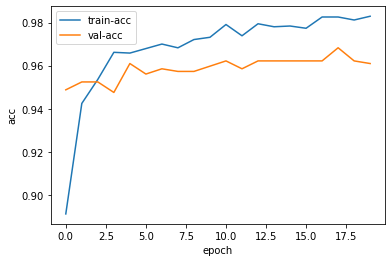

In [10]:
history_dict = history.history
plot_to(history_dict)